In this notebook, we will demonstrate how `TableAutomization.py` can be used for different distributions, in this case the `banana` distribution provided by the cuqipy package.
Please note that a previous read on the `table-donut.ipynb` is suggested, as that notebook provides more detailed explanations on `TableAutomization.py`; moreover, there are comparisons between the two notebooks.

### Importing the needed libraries 

In [1]:
from cuqi.distribution import DistributionGallery, Gaussian, JointDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS
import time
import scipy.stats as sps
from scipy.stats import gaussian_kde
import pandas as pd
import cProfile, pstats, io
from pstats import SortKey
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import sys
import math
sys.path.append(os.path.abspath('..'))
from utilities import TableAutomization as TA
import benchmarksClass as BC 


# The banana distribution


In [2]:
# The banana distribution 
target_banana = BC.Banana()


### Plotting the "banana"

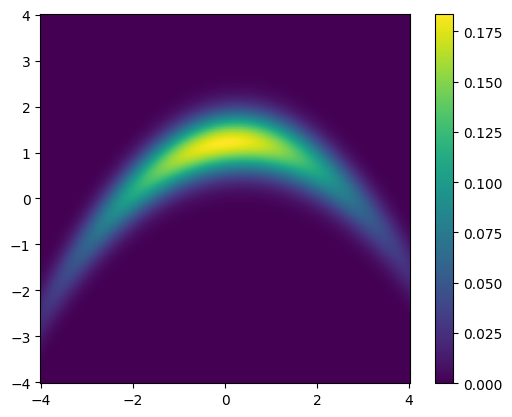

In [3]:
TA.plot_pdf_2D(target_banana, -4, 4, -4, 4)

- Compute sampling methods

In [4]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [5]:
df, (fig, axs) = TA.create_comparison(target_banana, [1.0, 1.0, 0.065, 0.5, 0.1], 8500, 1500, x0 = y, seed = 12, chains=4)

Sample 10000 / 10000

Average acceptance rate: 0.372 

Sample 10000 / 10000

Average acceptance rate all components: 0.5456470588235294 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000

Average acceptance rate: 0.3790588235294118 

Sample 10000 / 10000

Average acceptance rate all components: 0.5360588235294117 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000

Average acceptance rate: 0.37423529411764705 

Sample 10000 / 10000

Average acceptance rate all components: 0.5422352941176471 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000

Average acceptance rate: 0.3827058823529412 

Sample 10000 / 10000

Average acceptance rate all components: 0.5509411764705883 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000


In [6]:
TA.print_table(df)

+----------+---------+----------+-------+---------+---------+-------+--------+----------+----------+----------+
|  Method  | Samples | Burn-ins | Scale | ESS(v0) | ESS(v1) |   AR  | LogPDF | Gradient | Rhat(v0) | Rhat(v1) |
+----------+---------+----------+-------+---------+---------+-------+--------+----------+----------+----------+
| MH_fixed |   8500  |   1500   |  1.0  | 109.889 |  310.98 | 0.372 | 10000  |    0     |  1.007   |  1.003   |
|   CWMH   |   8500  |   1500   |  1.0  |  50.421 | 153.108 | 0.637 | 19999  |    0     |  1.023   |  1.007   |
|   ULA    |   8500  |   1500   | 0.065 |  31.378 |  63.144 |  1.0  | 10000  |  10000   |  1.041   |  1.013   |
|   MALA   |   8500  |   1500   |  0.5  |  75.038 |  204.49 | 0.507 | 10000  |  10000   |  1.003   |  1.004   |
|   NUTS   |   8500  |   1500   |   -   | 232.147 | 274.832 | 0.744 | 42961  |  42961   |  1.008   |  1.008   |
+----------+---------+----------+-------+---------+---------+-------+--------+----------+----------+----

Observations:
- the  MH_fixed performs quite poorly, as ESS is very low, RHat strays from 1 and the AR is too high
- however, unlike in the donut distribution, the MH_adapted, performs better than expected, with Rhat close to 1.0 (converges well) and ESS, especially ESS(v1), is quite high 
- ULA has acceptence rate AR=1.0, as expected, and it performs well, with ESS parameters not too high but higher than MH, also R_hat is close to 1, meaing that it converges well enough
- MALA performs decently, but NUTS outperforms all the methods, but the computational costs are at least 4 times higher

- Create distribution images  

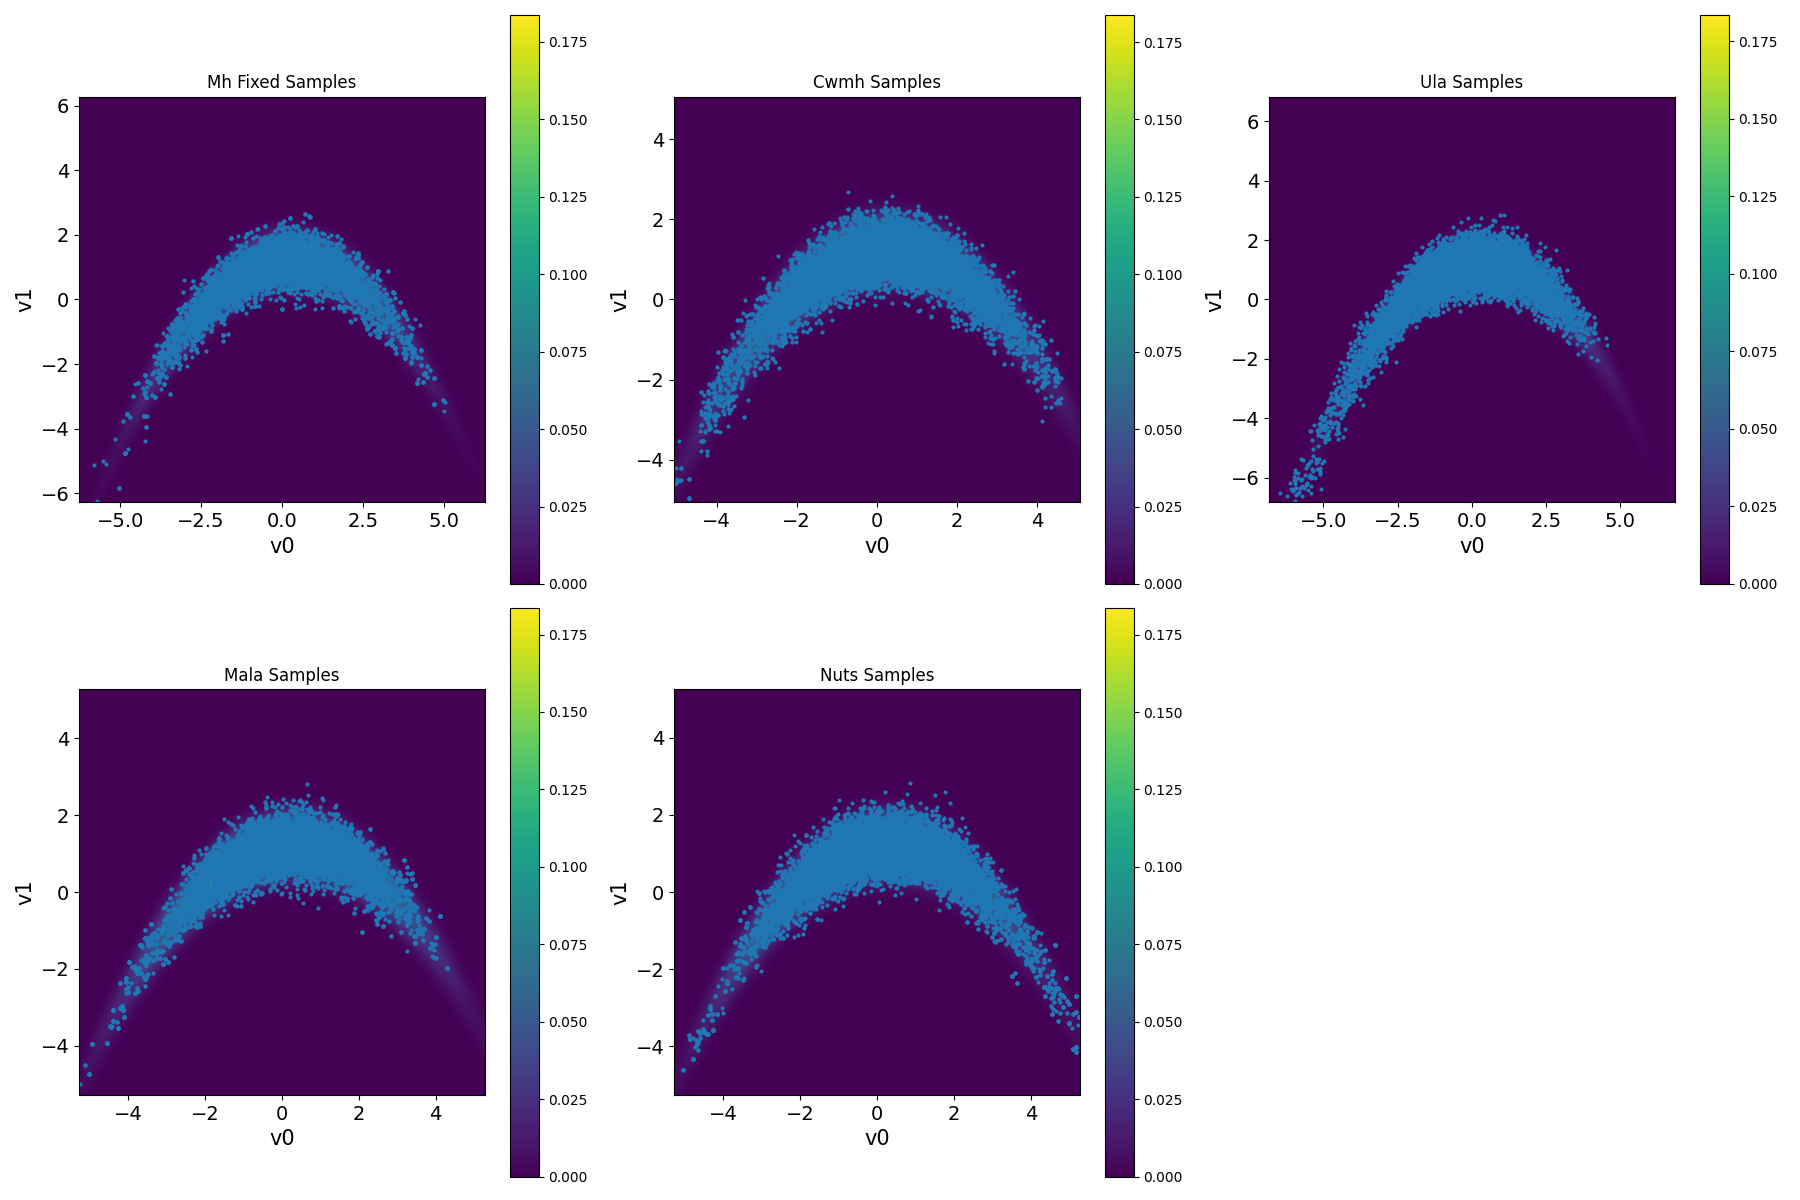

In [8]:
TA.show_plot(fig)

_Observations_
- as expected the MH_fixed stays quite close to the initial point  
- compared to the previous graphss,it can be seen that setting a relatively high number of burn ins will lead to better results 